In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from mist_cf import common
from mist_cf.common.plot_utils import *
set_style()

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
max_ind = 1e10
def get_match_ind_df(fast_filter_res, spec_to_form):
    """ Get match in df"""
    pred_forms = fast_filter_res['cand_form'].values
    fast_filter_res['cand_form'] = common.chunked_parallel(pred_forms,
                                                           common.standardize_form)
    def calc_match_ind(spec_input):
        spec, spec_group = spec_input
        true_form = spec_to_form[spec]
        sort_order = np.argsort(spec_group['scores'].values)[::-1]
        sorted_group = spec_group.iloc[sort_order].reset_index()
        is_match = sorted_group['cand_form'].values == true_form

        match_ind = np.argwhere(is_match).flatten()
        if len(match_ind) == 0:
            match_ind = max_ind
        elif len(match_ind) > 1:
            raise ValueError()
        else:
            # Break ties conservatively by picking last ind
            match_ind = match_ind[0]
            sorted_scores = sorted_group['scores'].values
            match_score = sorted_scores[match_ind]
            match_inds = np.where(sorted_scores == match_score)[0].flatten()

            # Add 1 to start at top 1 acc
            match_ind = np.max(match_inds) + 1
        return {"spec": spec, "match_ind": match_ind}
    
    entries = common.chunked_parallel(list(fast_filter_res.groupby("spec")),
                                      calc_match_ind)
    return pd.DataFrame(entries)

In [3]:
fig_folder = Path("../results/figures/fastfilter")
# mdkir
fig_folder.mkdir(parents=True, exist_ok=True)
data_folder = Path("../data/nist_canopus/")
rdbe_labels_file = data_folder / "decoy_labels/decoy_label_RDBE.tsv"
labels_file = data_folder / "labels.tsv"

In [4]:
labels = pd.read_csv(labels_file, sep="\t")
rdbe_labels = pd.read_csv(rdbe_labels_file, sep="\t")

## Plot distribution of rdbe labels

In [5]:
rdbe_labels.keys()

Index(['dataset', 'spec', 'formula', 'ionization', 'smiles', 'inchikey',
       'instrument', 'true_mass', 'decoy_formulae', 'decoy_ions',
       'decomp_recover', 'parentmass', 'abs_mass_diff', 'rel_mass_diff'],
      dtype='object')

In [6]:
rdbe_labels['decoy_formulae'].replace("[]", "", inplace=True)

In [7]:
# Freq of recovery in rdbe canopus
rdbe_labels[["nist" not in i for i in rdbe_labels['spec']]]['decomp_recover'].mean()

0.9672238304230086

In [8]:
decoy_forms = [i.split(",") for i in rdbe_labels['decoy_formulae']]

In [9]:
num_decoy_forms = np.array([len(i) for i in decoy_forms])

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


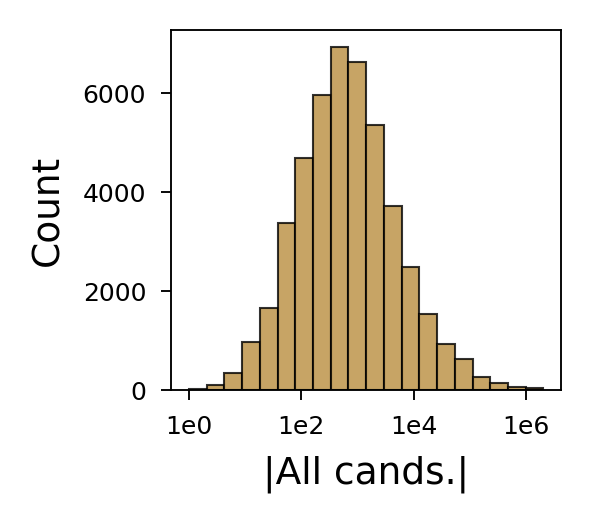

In [10]:
## Make plot of number of decoys
figsize = (1.3,1.2)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
# Norma
sns.distplot(np.log10(num_decoy_forms), kde=False, bins=20, 
             color=color_scheme["ffn_ms1"],
             
             # make log scale
             hist_kws=dict(log=False, alpha=0.8, 
                           linewidth=0.5, 
                           edgecolor="black",
                        #    density=True,
                        ))
ax.set_xticks([0, 1, 2, 3, 4, 5, 6][::2])
ax.set_xticklabels([f"1e{i}" for i in ax.get_xticks()])
ax.set_xlabel("|All cands.|")
ax.set_ylabel("Count")
# ax.set_xlim(0, 20)
# ax.set_ylim(0, 1000)

# sns.despine()
set_size(*figsize, ax=ax)
fig.savefig(fig_folder / "num_decoys_hist.pdf", 
            bbox_inches="tight",
            transparent=True)

In [11]:
# >9% of spectra have over 10k candidates by RDBE filter
# >15 of  ovehave over 5k candidates
print(f"Num spectra with > 5k candidates: {np.sum(np.array(num_decoy_forms) > 5000)} ({np.sum(np.array(num_decoy_forms) > 5000) / len(num_decoy_forms) * 100:.2f}%))")
print(f"Num spectra with > 10k candidates: {np.sum(np.array(num_decoy_forms) > 10000)} ({np.sum(np.array(num_decoy_forms) > 10000) / len(num_decoy_forms) * 100:.2f}%)")


Num spectra with > 5k candidates: 6955 (15.17%))
Num spectra with > 10k candidates: 4258 (9.29%)


## Plot fast filter

In [12]:
true_forms = labels['formula'].values
labels['formula'] = common.chunked_parallel(true_forms,
                                            common.standardize_form)
spec_to_form = dict(labels[["spec", "formula"]].values)

In [13]:
# Takes a little longer than we'd like
# Todo: move to analysis and export the top 1k ranks
split_to_res_df = {}
splits = ["split_1", "split_2", "split_3"]
for i in splits:
    fast_filter_res = Path(f"../results/fast_filter/split/preds_RDBE/{i}/formatted_output.tsv")
    fast_filter_res = pd.read_csv(fast_filter_res, sep="\t")
    match_ind_df = get_match_ind_df(fast_filter_res, spec_to_form)
    split_to_res_df[i] = match_ind_df

In [14]:

x_vals = np.arange(1000)
means, lbs, ubs = [], [], []
for x in x_vals:
    freqs = [(v['match_ind'].values < x).mean() 
             for k, v in split_to_res_df.items()]
    mean = np.mean(freqs)
    sem = np.std(freqs) / np.sqrt(len(freqs))
    # Get 95% conf interval
    ci = 1.96 * sem
    means.append(mean)
    lbs.append(mean - ci)
    ubs.append(mean + ci)

0.989941950717158


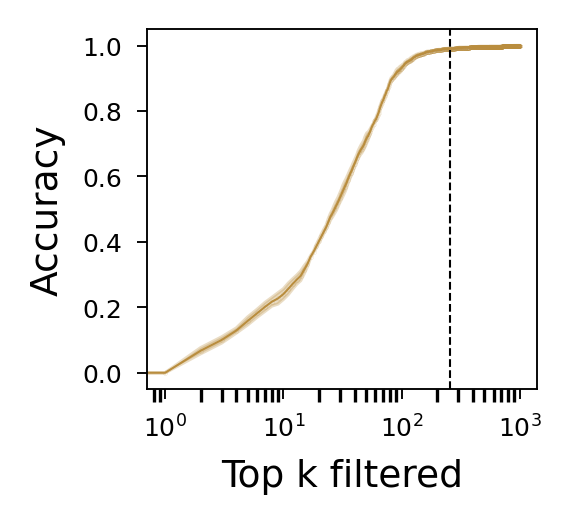

In [15]:
# Plot all values
figsize = (1.3,1.2)
fig, ax = plt.subplots(figsize=figsize, dpi=300)
color = color_scheme["ffn_ms1"]
ax.plot(x_vals, means, color=color, linewidth=0.5,
        marker=".", markersize=0.05, markerfacecolor="white",
        )
ax.fill_between(x_vals, lbs, ubs, color=color, alpha=0.3)
vline = 256
print(means[vline])
ax.axvline(vline, color="black", linestyle="--", linewidth=0.5)
ax.set_xlabel("Top k filtered")
ax.set_ylabel("Accuracy")
ax.set_xscale("log")
# Savefig
set_size(*figsize, ax=ax)
fig.savefig(fig_folder / "top_k_acc.pdf",
            bbox_inches="tight",
            transparent=True)